<a href="https://colab.research.google.com/github/bshazia/Apple_Stocks/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install yfinance==0.2.12

**Step 1: Data Collection**

In [219]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [220]:
#daily data for past 10 years
data_daily = yf.download("AAPL", period="10y", interval="1d")

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:517: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [180]:
data_daily.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-02,124.279999,125.239998,124.050003,125.059998,122.958435,59278900
2023-06-06,179.970001,180.119995,177.429993,179.210007,178.263306,64848400
2019-03-04,43.922501,44.437500,43.492500,43.962502,42.265331,109744800
2017-03-10,34.812500,34.840000,34.660000,34.785000,32.427551,78451200
2018-06-13,48.105000,48.220001,47.610001,47.674999,45.321133,86553600


Step 2: Data Preprocessing

In [181]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-08-08 to 2024-08-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [182]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [183]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-09', '2014-08-10', '2014-08-16', '2014-08-17',
               '2014-08-23', '2014-08-24', '2014-08-30', '2014-08-31',
               '2014-09-01', '2014-09-06',
               ...
               '2024-07-06', '2024-07-07', '2024-07-13', '2024-07-14',
               '2024-07-20', '2024-07-21', '2024-07-27', '2024-07-28',
               '2024-08-03', '2024-08-04'],
              dtype='datetime64[ns]', length=1137, freq=None)
Number of missing dates in daily data: 1137
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [184]:
#lets verify it with market calendar
#     !pip install pandas_market_calendars
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

Number of missing dates that are non-trading days: 1137


these are non-trading days and it's not impacting our data


In [185]:
# Previous day's closing price
data_daily['Close_Lag1'] = data_daily['Close'].shift(1)

data_daily['Close_MA5'] = data_daily['Close'].rolling(window=5).mean()
data_daily['Close_MA20'] = data_daily['Close'].rolling(window=20).mean()

In [186]:
# Calculate 5-day SMA
data_daily['SMA_5_'] = data_daily['Close'].rolling(window=5).sum() / 5

In [187]:
data_daily['SMA_5_'].sample(10)

,SMA_5_
Date,
2018-04-27,40.918501
2024-07-05,219.106000
2019-10-21,59.094500
2018-09-27,55.300500
2017-05-12,38.515500
2016-05-31,24.907000
2016-05-13,22.979000
2015-03-24,31.788500
2021-07-06,138.508005


**Training**

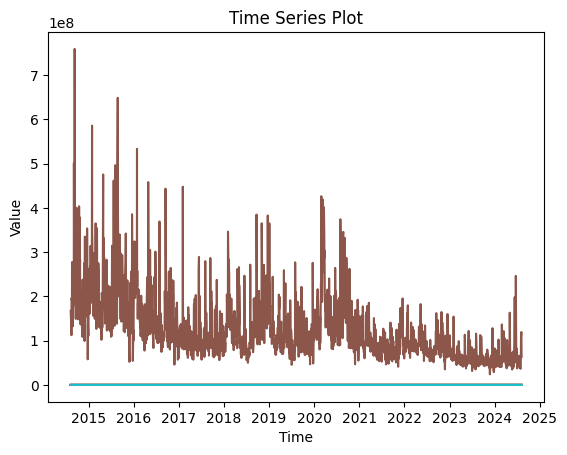

In [188]:
#checking for trend
import matplotlib.pyplot as plt

plt.plot(data_daily)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()

In [204]:
features = ['Close_Lag1', 'Close_MA5', 'Open',	'High'	,'Low']
x = data_daily[features]
y = data_daily['Close'][x.index]

In [205]:
# Handle missing values (due to lagged features)
x = x.dropna()
y = y[x.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


In [206]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [207]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [214]:
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.9571
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.0493
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.8689
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.3700
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.8704
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.3691
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.5826
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.9590
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.8663
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.9308
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.4354
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.3483
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.1035
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.8617
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.4628
Epoc

**Evaluation**

In [215]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [216]:
# Evaluate performance (flatten predictions for metrics)
mse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten())
rmse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten(), squared=False)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm.flatten())

print("LSTM - MSE:", mse_lstm, "RMSE:", rmse_lstm, "MAE:", mae_lstm)

LSTM - MSE: 448.47301044342584 RMSE: 21.177181362103546 MAE: 15.792859799819249


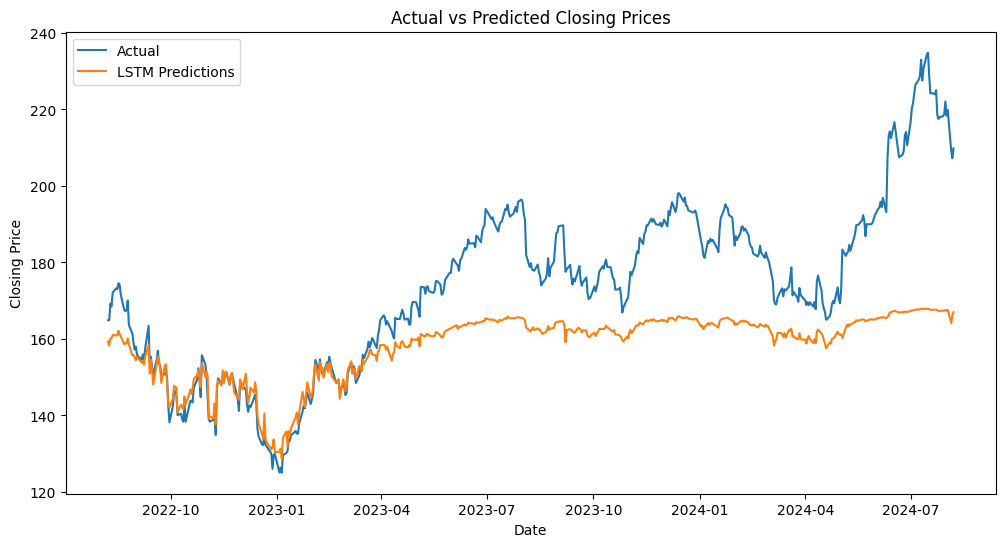

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

cheking with prophit now

In [ ]:
# Create a DataFrame for Prophet
df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
df_test = pd.DataFrame({'ds': X_test.index, 'y': y_test})